In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [2]:
taxi_trip_jan = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")

In [3]:
original_datapoints = taxi_trip_jan.shape[0]

In [4]:
print("The number of columns :", taxi_trip_jan.shape[1])

The number of columns : 19


In [5]:
categorical = ['PULocationID', 'DOLocationID']

In [6]:
taxi_trip_jan = taxi_trip_jan.dropna(subset=categorical)


In [7]:
taxi_trip_jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [8]:
taxi_trip_jan.tpep_dropoff_datetime = pd.to_datetime(taxi_trip_jan.tpep_dropoff_datetime) 

In [9]:
taxi_trip_jan.tpep_pickup_datetime =  pd.to_datetime(taxi_trip_jan.tpep_pickup_datetime)

In [10]:
taxi_trip_jan['duration'] = (taxi_trip_jan.tpep_dropoff_datetime - taxi_trip_jan.tpep_pickup_datetime).apply(lambda td: td.total_seconds()/60)

In [11]:
taxi_trip_jan.duration = taxi_trip_jan.duration.astype(float)

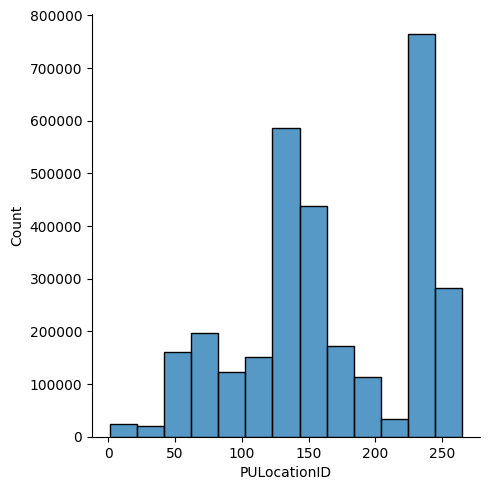

In [12]:
sns.displot(data=taxi_trip_jan, x="PULocationID",  binwidth=20)

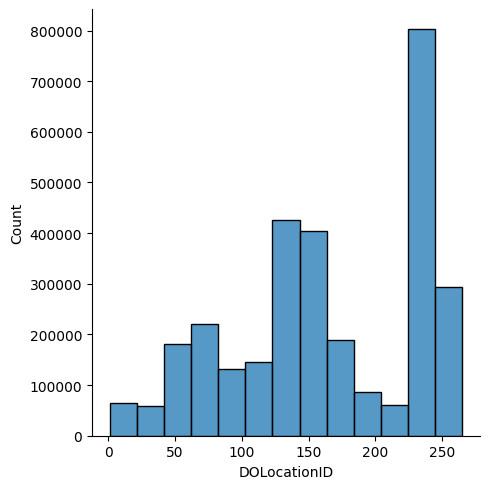

In [13]:
sns.displot(data=taxi_trip_jan, x="DOLocationID",  binwidth=20)

In [14]:
taxi_trip_jan.duration.std()

42.594351241920904

In [15]:
original_datapoints = taxi_trip_jan.duration.shape[0]

In [16]:
taxi_trip_jan =  taxi_trip_jan[(taxi_trip_jan.duration <= 60) & (taxi_trip_jan.duration >=1)]

In [17]:
current_datapoints = taxi_trip_jan.duration.shape[0]

In [18]:
dropped_outliers =  (original_datapoints- current_datapoints)/original_datapoints

In [19]:
dropped_outliers*100

1.8779717787402104

In [20]:
dv = DictVectorizer()

In [21]:
taxi_trip_jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [22]:
def preprocessor(df):
    

    
    
    numerical = ['trip_distance']

    df.dropna(subset=categorical+numerical, inplace= True)

    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime =  pd.to_datetime(df.tpep_pickup_datetime)
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).apply(lambda td: td.total_seconds()/60)
    df =  df[(taxi_trip_jan.duration <= 60) & (df.duration >=1)]
    target = 'duration'
    
    y = df[target].values


    return df, y
    

In [23]:
df_train = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_val = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')

In [24]:
df_train, y_train = preprocessor(df_train)
df_val , y_val= preprocessor(df_val)


/tmp/ipykernel_2044/1495663249.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df =  df[(taxi_trip_jan.duration <= 60) & (df.duration >=1)]


In [25]:
categorical = ['PULocationID', 'DOLocationID']

In [27]:
df_train[categorical] = df_train[categorical].astype(str)

df_val[categorical] = df_val[categorical].astype(str)

In [28]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [29]:
df_train['PU_DO'] = df_train['PU_DO'].astype(str)
df_val['PU_DO'] = df_val['PU_DO'].astype(str)

In [50]:
# categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

train_dict = df_train[categorical + numerical].to_dict(orient="records")
val_dict = df_val[categorical + numerical].to_dict(orient="records")
combined_data = pd.concat([df_train, df_val], ignore_index=True)

combined_dict = combined_data.to_dict(orient="records")

dv = DictVectorizer()
dv.fit(combined_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

In [51]:

# dv = DictVectorizer()
# X_train = dv.fit_transform(train_dict)
# X_val = dv.fit_transform(val_dict)

In [52]:

lr = LinearRegression()

In [53]:
lr.fit(X_train,y_train)


LinearRegression()

In [54]:
df_train.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration',
       'PU_DO'],
      dtype='object')

In [55]:



y_pred = lr.predict(X_train)

In [56]:

mean_squared_error(y_train,y_pred, squared= False)

/home/mlops_zoomcamp/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.133172177224767

In [57]:


y_preds= lr.predict(X_val)

In [58]:
mean_squared_error(y_val,y_preds, squared= False)

/home/mlops_zoomcamp/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


41.923345695221855